<a href="https://colab.research.google.com/github/joaopedro169/Processo-seletivo-Daedalus/blob/main/Questao1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baixando o arquivo

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h --output KITTI-Sequence.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h
To: /content/KITTI-Sequence.zip
100% 18.0M/18.0M [00:00<00:00, 126MB/s] 


In [ ]:
!gdown --id 10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM --output ground_truth.npy

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM
To: /content/ground_truth.npy
100% 3.97k/3.97k [00:00<00:00, 8.80MB/s]


In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile

import os

In [ ]:
with zipfile.ZipFile('/content/KITTI-Sequence.zip', 'r') as zip_ref:
    zip_ref.extractall('.')  

In [ ]:
import copy

obj_path_list = []

n_arquivos=29
for i in range(1, n_arquivos+1):
    filename = f'/content/000{i:03d}/000{i:03d}_points.obj'
    obj_path_list.append(filename)

In [ ]:
lista_scan = []
for scan in obj_path_list:
  lista_scan.append(trimesh.load(scan).vertices)

In [ ]:
point_cloud_referencia = lista_scan[0]

In [ ]:
def find_corresponding_points(source, target, radius=0.5):
    distance = np.sqrt(np.sum((source - target)**2, axis=1))
    
    indice = np.argmin(distance, axis=0)
   
    distance = np.min(distance, axis=0)
    
    corresponding_distances = []
    corresponding_indices = []
    

    indices.append(indice)
    distances.append(distance)
    
    for i in range(len(distances)):
        if distances[i] < radius:
            corresponding_distances.append(distances[i])
            corresponding_indices.append(indices[i])

    return np.array(corresponding_distances), np.array(corresponding_indices)


In [ ]:
def rigid_transformation(source, target):

    centroid_source = np.mean(source, axis=0)
    centroid_target = np.mean(target, axis=0)
    

    H = np.dot((source - centroid_source).T, target - centroid_target)
    
 
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)
    
 
    t = centroid_target - np.dot(R, centroid_source)
    

    T = np.identity(4)
    T[:3,:3] = R
    T[:3,3] = t
    return T

In [ ]:
def icp(source, target, max_iter=200, tolerance=1e-6):

    source = source[:58000, :]
    target = target[:58000, :]
    
    T = np.identity(4)
    
    for i in range(max_iter):
        
        distances, indices = find_corresponding_points(source, target)
        
        T_k = rigid_transformation(source[indices], target[indices])
        
        T = np.dot(T_k, T)
        
        source = np.dot(T_k[:3,:3], source.T).T + T_k[:3,3]
        
        if np.sum(distances) < tolerance:
            break
    
    return T


<ipython-input-39-c5be60d6add9>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(point_cloud_transformed[:, 0], point_cloud_transformed[:, 1], point_cloud_transformed[:, 2], s=10, cmap="red")
<ipython-input-39-c5be60d6add9>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(lista_scan[i][:, 0], lista_scan[i][:, 1], lista_scan[i][:, 2], s=1, cmap="blue")


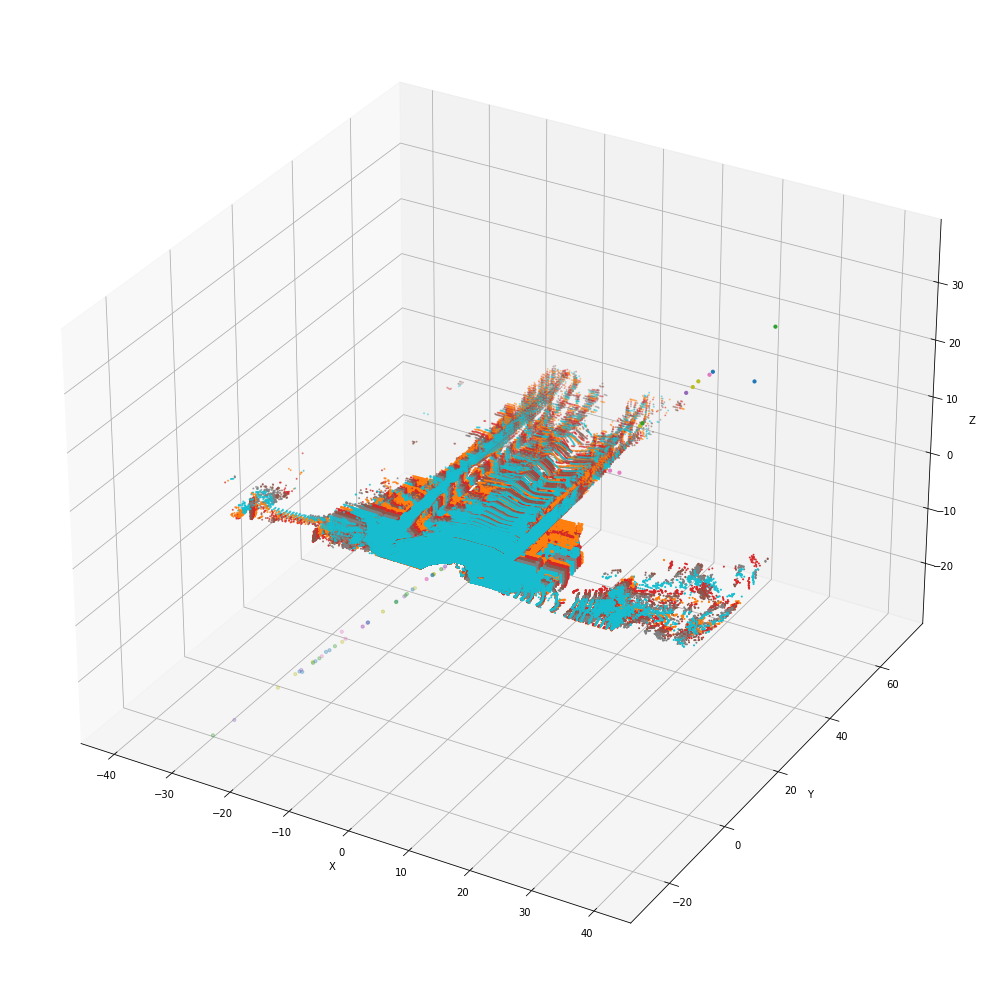

In [ ]:
ground_truth = np.load('ground_truth.npy')

trajectory = np.zeros((30, 4, 4))
trajectory[0] = np.identity(4)

indices=[]
distances=[]

point_clouds = lista_scan


fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')

for i in range(1, len(lista_scan)):
    T_k = icp(lista_scan[0], lista_scan[i])
    T_matrices_1 = T_k

    trajectory[i] = np.dot(T_k, trajectory[i-1])
    
    point_cloud_transformed = np.dot(T_matrices_1, np.vstack([point_clouds[i].T, np.ones((1, point_clouds[i].shape[0]))])).T
    point_cloud_transformed = point_cloud_transformed[:3].T

    ax.scatter(point_cloud_transformed[:, 0], point_cloud_transformed[:, 1], point_cloud_transformed[:, 2], s=10, cmap="red")
    ax.scatter(lista_scan[i][:, 0], lista_scan[i][:, 1], lista_scan[i][:, 2], s=1, cmap="blue")


   
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


plt.show()


In [ ]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)

<ipython-input-25-6f8b66e5df21>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(point_cloud_transformed[:, 0], point_cloud_transformed[:, 1], point_cloud_transformed[:, 2], s=10, cmap="red")
<ipython-input-25-6f8b66e5df21>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(lista_scan[i][:, 0], lista_scan[i][:, 1], lista_scan[i][:, 2], s=1, cmap="blue")


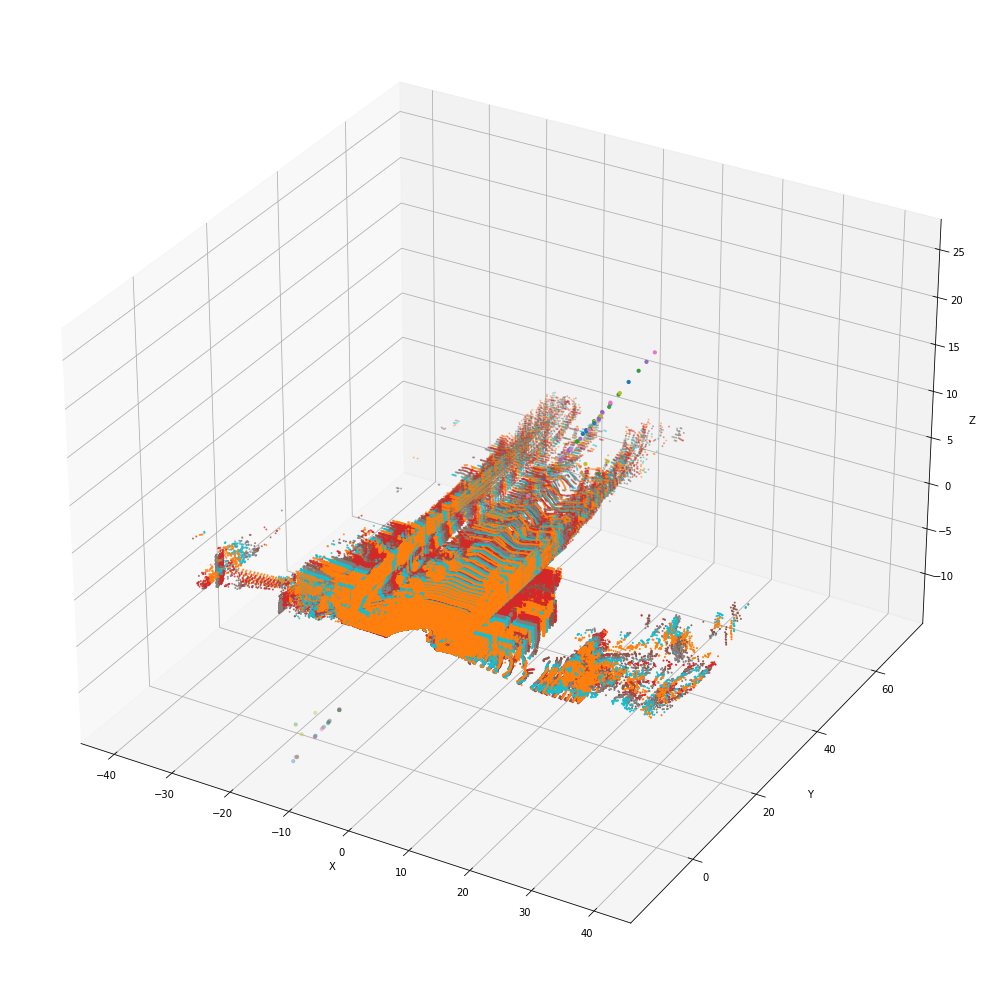

In [ ]:
point_clouds = lista_scan
T_matrices = np.load('ground_truth.npy')


fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')



for i in range(len(point_clouds)):
  
    point_cloud_transformed = np.dot(T_matrices[i], np.vstack([point_clouds[i].T, np.ones((1, point_clouds[i].shape[0]))])).T
    point_cloud_transformed = point_cloud_transformed[:3].T

    ax.scatter(point_cloud_transformed[:, 0], point_cloud_transformed[:, 1], point_cloud_transformed[:, 2], s=10, cmap="red")
    ax.scatter(lista_scan[i][:, 0], lista_scan[i][:, 1], lista_scan[i][:, 2], s=1, cmap="blue")


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


plt.show()
